In [6]:
from fastbook import *

In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *

### Step 1: Download images of bird and non-birds 

In [9]:
def search_images(term, max_images=200): 
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [10]:
# Let's start by searching for a bird photo and seeing what kind of result we get. 
# We'll start by getting URLs from a search:

urls = search_images('bird photos', max_images=1)
urls[0]

'http://2.bp.blogspot.com/-TA1D79yxcnM/Tyy6ng42rbI/AAAAAAAAAnc/-4s-bZaYc_U/s1600/colorfull+bird+HD+wallpaper.jpg'

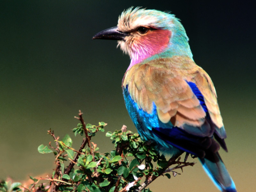

In [12]:
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
img = Image.open(dest)
img.to_thumb(256,256)

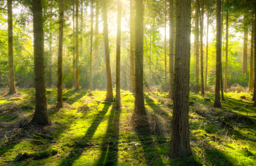

In [13]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Now let's grab 200 examples of brid and forest photos, and save each group of photos to a different folder:

In [14]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

### Step 2: Train our model

Some photos might not downloads correctly which could cause our model training to fail, so we'll remove them:

In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

25

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* and *valuation set*. In `fastai` we can create that easily using a `DataBlock`, and view samples images from it.

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: The MPS backend is supported on MacOS 12.3+.Current OS version can be queried using `sw_vers`

Here what rach of the `DataBlock` parameters means:

`blocks=(ImageBlock, CategoryBlock)`

The inputs to our model are images, and the outputs are actegories


`item_tfms=[Resize(192, method='squish')]`

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).



In [17]:
learn = cnn_learner(dls, resnet18, metircs=errorrate)
learn.fine_tune(3)

NameError: name 'dls' is not defined

### Step 3: Use out model

Let's see what our model thinks about the bird we downloaded at start

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create("bird.jpg"))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")